<a href="https://colab.research.google.com/github/Carlosrnes/Nova_NLP/blob/main/NLP_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### GPU

In [1]:
# Check GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-05fdf5dd-9262-75a2-2842-acd8e986ec81)


In [2]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U "tensorflow-text==2.8.*"

     |████████████████████████████████| 4.9 MB 4.9 MB/s 


### Libraries

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import pandas as pd
pd.set_option('display.max_colwidth', 150)
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re

import tqdm
import sys
np.set_printoptions(threshold=sys.maxsize)

from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import f1_score
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from bs4 import BeautifulSoup


import tensorflow_hub as hub
import tensorflow as tf
import tensorflow_text as text
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras import layers

### Get the data

In [67]:
train_df = pd.read_csv("https://raw.githubusercontent.com/Carlosrnes/Nova_NLP/main/data/training_set.txt", sep="\t")
valid_df = pd.read_csv("https://raw.githubusercontent.com/Carlosrnes/Nova_NLP/main/data/dev_set.txt", sep="\t")
test_df = pd.read_csv("https://raw.githubusercontent.com/Carlosrnes/Nova_NLP/main/data/test_set.txt", sep="\t")
train_df.head(1)

,sentence,emotion
0,I'm too old to be traded in .,6


### Explore Dataset

In [64]:
# check if the emotions are correctly defined:
print(np.sort(train_df['emotion'].unique()))

# check the distribution of sentences in each emotion class:
df = train_df.groupby('emotion').count().reset_index()
sum_total = df['sentence'].sum()
df['perc_total'] = round(df['sentence']/sum_total,2)
df['dataset'] = 'Train'
df

[1 2 3 4 5 6 7 8]


,emotion,sentence,perc_total,dataset
0,1,2999,0.21,Train
1,2,2129,0.15,Train
2,3,1343,0.10,Train
3,4,1442,0.10,Train
4,5,1470,0.10,Train
5,6,1384,0.10,Train
6,7,1138,0.08,Train
7,8,2095,0.15,Train


In [ ]:
# size of the dataset and null values
train_df.info()

In [6]:
# Samples
print(f"Total training samples: {len(train_df)}")
print(f"Total valid samples: {len(valid_df)}")
print(f"Total samples: {len(train_df) + len(valid_df)}")

Total training samples: 14000
Total valid samples: 1000
Total samples: 15000


### Baseline Model

In [ ]:
train = train_df.copy()
val = valid_df.copy()

In [44]:
#minimal preprocessing
train.dropna(inplace=True)
train.emotion=train.emotion-1
train.emotion=train.emotion.astype("int")
train= train.reset_index(drop=True)

In [45]:
#feature extraction 
vectorizer = TfidfVectorizer(stop_words="english", max_df=.8)
X = vectorizer.fit_transform(train.sentence).toarray()
Y = train.emotion
X.shape, Y.shape

((14000, 7185), (14000,))

In [46]:
#applying the same steps to validation data
val = pd.read_csv("data/dev_set.txt",sep=" .	",engine='python', names=["sentence","emotion"],skiprows=1 )
val.dropna(inplace=True)
val.emotion=val.emotion-1
val.emotion=val.emotion.astype("int")
val= val.reset_index(drop=True)

X_test = vectorizer.transform(val.sentence).toarray()
Y_test = val.emotion
X_test.shape, Y_test.shape

((968, 7185), (968,))

In [47]:
clf = LogisticRegression(random_state=0, max_iter=1000, class_weight='balanced').fit(X, Y)
Y_pred = clf.predict(X_test)

In [48]:
score = clf.score(X_test, Y_test)
print('accuracy: ', score)

accuracy:  0.32541322314049587


In [49]:
print(
    f"Classification report for classifier {clf}:\n"
    f"{metrics.classification_report(Y_test, Y_pred)}\n"
)

Classification report for classifier LogisticRegression(class_weight='balanced', max_iter=1000, random_state=0):
              precision    recall  f1-score   support

           0       0.41      0.21      0.28       205
           1       0.38      0.38      0.38       165
           2       0.14      0.28      0.19        72
           3       0.33      0.37      0.35       102
           4       0.38      0.45      0.41        97
           5       0.31      0.35      0.33        81
           6       0.32      0.44      0.37        94
           7       0.37      0.26      0.30       152

    accuracy                           0.33       968
   macro avg       0.33      0.34      0.33       968
weighted avg       0.35      0.33      0.33       968




### Preprocessing

Now that we have a baseline score (.214), we can try additional preprocessing to improve the score, as well as different models and embessing layers.

In [50]:
def preprocessing(dataframe, column):
    
    processed_corpus = []
    stop_words = set(stopwords.words("english"))
    
    for i in (range(len(dataframe))):
        text = dataframe[column].iloc[i]
        
        # Remove tags
        text = BeautifulSoup(text).get_text()
        
        # Remove punctuations - mantain only the final . or !
        text = re.sub("[^a-zA-z!.?:'\s]", '', text)
        text = re.sub("[.]{2,}", '', text)
        text = re.sub("[?]", "questionmark", text)
        text = re.sub("[!]", "exclamationmark", text)

        # Convert to lowercase
        text = text.lower()        
        
        # Convert to list from string
        text = text.split()

        # Lemmatization
        lem = WordNetLemmatizer()
        text = [lem.lemmatize(word) for word in text if not word in stop_words] 
        text = " ".join(text)
        processed_corpus.append(text)
    dataframe['sentence_prep'] = processed_corpus
        
    return dataframe

In [51]:
#reimport data
train = pd.read_csv("data/training_set.txt", sep="	", engine='python', names=["sentence","emotion"], skiprows=1)
test = pd.read_csv("data/dev_set.txt", sep="	", engine='python', names=["sentence","emotion"], skiprows=1)

In [52]:
train = preprocessing(train, 'sentence')

C:\Users\mdurh\anaconda3\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [53]:
train.sample(10)

,sentence,emotion,sentence_prep
12447,"Listen , I - I know you're gonna think this is real dumb of me , but , uh , I haven't been feeling very good lately , and , uh ...",2,listen know gonna think real dumb uh feeling good lately uh
7142,At least they can dream .,5,least dream .
1232,"You're not gonna give him a chance , are you ?",4,gonna give chance questionmark
8071,How can you be so mean ?,3,mean questionmark
5589,What if I could get you the money you're waiting for before midnight ?,8,could get money waiting midnight questionmark
11313,I shall wish a book jacket that is only letters .,8,shall wish book jacket letter .
11745,"With what money , and what about us ?",4,money u questionmark
3925,Want to see a strange object ?,2,want see strange object questionmark
11309,Wait till I ask Dad if this is any way to run an airline .,1,wait till ask dad way run airline .
10322,I'd like to introduce you to ...,2,i'd like introduce


In [54]:
#feature extraction 
vectorizer = TfidfVectorizer(stop_words=None, max_df=.8, strip_accents='unicode', lowercase=False, analyzer='word')
X = vectorizer.fit_transform(train['sentence_prep']).toarray()
Y = train['emotion']
X.shape, Y.shape

((14000, 6582), (14000,))

In [55]:
test = preprocessing(test, 'sentence')

In [56]:
X_test = vectorizer.transform(test['sentence_prep']).toarray()
Y_test = test['emotion']
X_test.shape, Y_test.shape

((1000, 6582), (1000,))

### Model w/ Preprocessing - LogisticRegression

In [57]:
clf = LogisticRegression(random_state=0, max_iter=1000, class_weight='balanced').fit(X, Y)
Y_pred = clf.predict(X_test)

In [58]:
score = clf.score(X_test, Y_test)
print('accuracy: ', score)

accuracy:  0.361


In [59]:
print(
    f"Classification report for classifier {clf}:\n"
    f"{metrics.classification_report(Y_test, Y_pred)}\n"
)

Classification report for classifier LogisticRegression(class_weight='balanced', max_iter=1000, random_state=0):
              precision    recall  f1-score   support

           1       0.48      0.26      0.34       211
           2       0.39      0.35      0.37       170
           3       0.24      0.38      0.29        77
           4       0.33      0.38      0.35       104
           5       0.40      0.45      0.43        97
           6       0.27      0.37      0.31        87
           7       0.34      0.47      0.39        96
           8       0.44      0.36      0.40       158

    accuracy                           0.36      1000
   macro avg       0.36      0.38      0.36      1000
weighted avg       0.39      0.36      0.36      1000




In [60]:
cm = metrics.confusion_matrix(Y_test, Y_pred)
print(cm)
cm = pd.DataFrame(cm, index=range(1,9), columns=range(1,9))

[[55 21 32 26  8 26 26 17]
 [14 60 16 16 17  9 23 15]
 [ 8 10 29  5  4  6  7  8]
 [ 7  7  9 39  3 18 10 11]
 [ 4  6  8  4 44 10  9 12]
 [11 12  8  6  7 32  5  6]
 [ 3 15  3 14  4  8 45  4]
 [12 21 18  8 23 10  9 57]]


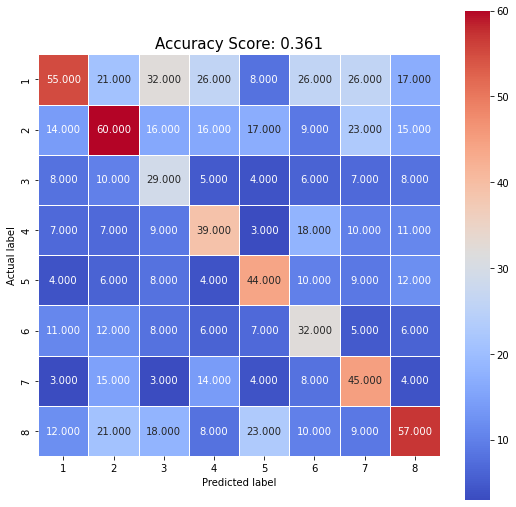

In [61]:
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'coolwarm');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

In [62]:
feature_names = vectorizer.get_feature_names_out()

In [30]:
print(feature_names)

['aa' 'aarfy' 'abandoned' 'abandoning' 'abdominal' 'abercrombie' 'abide'
 'ability' 'able' 'ably' 'aboard' 'abracadabra' 'absence' 'absolute'
 'absolutely' 'absolve' 'absolved' 'absurd' 'absurdly' 'abundance' 'abuse'
 'abused' 'abusive' 'accent' 'accept' 'acceptable' 'accepted' 'accepts'
 'access' 'accessory' 'accident' 'accommodate' 'accomplish' 'according'
 'account' 'accountable' 'accountant' 'accusation' 'accuse' 'accused'
 'accuses' 'ace' 'ache' 'ached' 'aching' 'acid' 'acknowledge'
 'acknowledging' 'acquaintance' 'acquainted' 'acquisition' 'acre' 'across'
 'act' 'acted' 'acting' 'action' 'active' 'activity' 'actress' 'actual'
 'actually' 'ad' 'adalind' 'add' 'addicted' 'additional' 'address' 'adept'
 'adiran' 'administration' 'administrative' 'admiral' 'admire' 'admired'
 'admiring' 'admission' 'admit' 'admitting' 'adolescence' 'adolescent'
 'adopt' 'adopted' 'adoption' 'adore' 'adrian' 'adrift' 'adult' 'advance'
 'advantage' 'adventure' 'advertising' 'advice' 'advise' 'adviser'


### Transform training, validation and test sets to Numpy

In [7]:
# Transform to numpy
train_sentences = train_df["sentence"].to_numpy()
val_sentences = valid_df["sentence"].to_numpy()
test_sentences = test_df["sentence"].to_numpy()
train_labels = train_df["emotion"].to_numpy()
val_labels = valid_df["emotion"].to_numpy()


# Check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels), len(test_sentences)

(14000, 14000, 1000, 1000, 2000)

### Tokenization

In [8]:
# The default TextVectorization variables
text_vectorizer = TextVectorization(max_tokens=None,
                                    standardize="lower_and_strip_punctuation", 
                                    split="whitespace", 
                                    ngrams=None, 
                                    output_mode="int", 
                                    output_sequence_length=None) 

In [9]:
# Average number of tokens (words) in training set
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

9

In [10]:
# Setup text vectorization with custom variables
max_vocab_length = 10000
max_length = 9

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [11]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [12]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(words_in_vocab)}")

Number of words in vocab: 7656


In [13]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'idf_weights': None,
 'max_tokens': 10000,
 'name': 'text_vectorization_1',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 9,
 'pad_to_max_tokens': False,
 'ragged': False,
 'sparse': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True,
 'vocabulary': None}

### Embedding

In [14]:
tf.random.set_seed(42)

embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128, # set size of embedding vector
                             embeddings_initializer="uniform", # default, intialize randomly
                             input_length=max_length, # how long is each input
                             name="embedding_1") 

embedding

In [15]:
# One hot encode labels
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_labels.reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_labels.reshape(-1, 1))

# Check what training labels look like
train_labels_one_hot

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [16]:
# Turn data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(8,), dtype=tf.float64, name=None))>

In [17]:
# Take the TensorSliceDataset's and turn them into prefetched batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 8), dtype=tf.float64, name=None))>

### Create Models

In [18]:
# Function to evaluate: accuracy, precision, recall, f1-score

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

#### Model 1 - A simple dense model

In [19]:
# Create 1D convolutional model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = embedding(text_vectors) # create embedding
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector
outputs = layers.Dense(8, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [20]:
# Compile model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [21]:
# Get a summary of the model
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 9)                0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 9, 128)            1280000   
                                                                 
 conv1d (Conv1D)             (None, 9, 64)             41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 8)                 520   

In [22]:
# Fit the model
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(len(valid_dataset))) 

Epoch 1/3
438/438 [==============================] - 19s 9ms/step - loss: 1.9133 - accuracy: 0.2699 - val_loss: 1.7532 - val_accuracy: 0.3510
Epoch 2/3
438/438 [==============================] - 3s 6ms/step - loss: 1.5514 - accuracy: 0.4454 - val_loss: 1.7390 - val_accuracy: 0.3620
Epoch 3/3
438/438 [==============================] - 4s 8ms/step - loss: 1.2572 - accuracy: 0.5724 - val_loss: 1.8591 - val_accuracy: 0.3550


In [23]:
# Make predictions
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs

array([[0.01925442, 0.40411887, 0.00680164, ..., 0.01223091, 0.00496434,
        0.22463526],
       [0.12202242, 0.01194044, 0.04783471, ..., 0.28316745, 0.01008671,
        0.06522798],
       [0.00946379, 0.02571615, 0.00844525, ..., 0.01820526, 0.05136825,
        0.08076279],
       ...,
       [0.5266714 , 0.19861057, 0.03513527, ..., 0.00694043, 0.05070744,
        0.07130747],
       [0.05422463, 0.08013153, 0.15507077, ..., 0.13004048, 0.13392441,
        0.09900999],
       [0.16303611, 0.22051178, 0.03180406, ..., 0.05660051, 0.04634143,
        0.25960347]], dtype=float32)

In [24]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1) + 1
model_1_preds

<tf.Tensor: shape=(1000,), dtype=int64, numpy=
array([2, 4, 5, 2, 1, 1, 7, 3, 1, 5, 5, 6, 1, 5, 2, 1, 2, 1, 1, 2, 5, 5,
       3, 1, 1, 8, 5, 4, 2, 2, 2, 7, 5, 2, 6, 4, 1, 8, 8, 2, 2, 4, 1, 1,
       1, 2, 1, 1, 8, 8, 2, 2, 5, 5, 6, 8, 1, 3, 2, 3, 1, 7, 1, 8, 6, 8,
       2, 8, 2, 2, 1, 6, 6, 8, 2, 2, 8, 1, 2, 7, 2, 1, 5, 8, 8, 4, 1, 8,
       8, 4, 2, 1, 3, 2, 8, 1, 4, 1, 1, 5, 4, 8, 2, 1, 6, 2, 8, 7, 2, 7,
       2, 8, 1, 1, 6, 8, 5, 5, 5, 7, 5, 8, 2, 8, 7, 7, 3, 2, 2, 8, 2, 4,
       1, 3, 4, 1, 1, 2, 1, 3, 5, 5, 2, 3, 8, 8, 5, 6, 1, 4, 8, 8, 7, 1,
       1, 2, 7, 5, 7, 5, 6, 2, 4, 3, 8, 2, 2, 5, 3, 3, 2, 2, 2, 1, 1, 6,
       8, 7, 8, 6, 5, 5, 7, 8, 2, 8, 2, 8, 8, 7, 6, 6, 6, 4, 2, 2, 2, 8,
       1, 8, 1, 8, 1, 3, 1, 5, 8, 2, 2, 3, 5, 3, 5, 8, 6, 1, 2, 2, 1, 3,
       5, 4, 7, 7, 5, 3, 8, 8, 8, 8, 2, 4, 2, 1, 2, 5, 6, 7, 2, 8, 4, 1,
       2, 2, 2, 6, 3, 5, 8, 8, 2, 6, 7, 7, 1, 4, 4, 2, 7, 1, 3, 1, 3, 4,
       5, 1, 4, 8, 2, 8, 1, 6, 2, 1, 1, 2, 1, 3, 8, 1, 1, 1, 1, 8, 8, 8,
    

In [25]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 35.5,
 'f1': 0.3522124269586234,
 'precision': 0.35562377208793644,
 'recall': 0.355}

#### Model 2 - Feature extraction with pretrained token embeddings - Universal Sentence Encoder

In [26]:
# Download pretrained TensorFlow Hub universal sentence encoder

tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [27]:
# Define feature extractor model using TF Hub layer
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embedding
x = layers.Dense(128, activation="relu")(pretrained_embedding) # add a fully connected layer on top of the embedding
x = layers.Dense(128, activation="relu")(x) # add a fully connected layer on top of the embedding
outputs = layers.Dense(8, activation="softmax")(x) # create the output layer
model_2 = tf.keras.Model(inputs=inputs,
                        outputs=outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary of the model
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 8)                 1032      
                                                                 
Total params: 256,881,032
Trainable params: 83,208
Non-trainable params: 256,797,824
________________________________________

In [28]:
# Fit feature extractor model for 3 epochs
model_2.fit(train_dataset,
            steps_per_epoch=int(len(train_dataset)),
            epochs=3,
            validation_data=valid_dataset,
            validation_steps=int(len(valid_dataset)))

Epoch 1/3
438/438 [==============================] - 12s 11ms/step - loss: 1.6562 - accuracy: 0.3866 - val_loss: 1.5468 - val_accuracy: 0.4350
Epoch 2/3
438/438 [==============================] - 5s 11ms/step - loss: 1.4813 - accuracy: 0.4616 - val_loss: 1.5364 - val_accuracy: 0.4440
Epoch 3/3
438/438 [==============================] - 5s 11ms/step - loss: 1.4347 - accuracy: 0.4775 - val_loss: 1.5376 - val_accuracy: 0.4580


In [29]:
# Make predictions with feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

array([[0.03853206, 0.19867864, 0.01085741, ..., 0.02084739, 0.0126064 ,
        0.09305403],
       [0.05414039, 0.08543688, 0.05898725, ..., 0.33492014, 0.11734294,
        0.124318  ],
       [0.05036435, 0.04177938, 0.01777322, ..., 0.1116325 , 0.38502666,
        0.07196869],
       ...,
       [0.79743457, 0.05824201, 0.01270586, ..., 0.0044113 , 0.00856827,
        0.06074514],
       [0.0630599 , 0.45517784, 0.01713153, ..., 0.0193417 , 0.29449823,
        0.0867078 ],
       [0.05906989, 0.35715607, 0.01876134, ..., 0.01033775, 0.06410109,
        0.1122647 ]], dtype=float32)

In [30]:
# Convert the predictions with feature extraction model to classes
model_2_preds = tf.argmax(model_2_pred_probs, axis=1) + 1
model_2_preds

<tf.Tensor: shape=(1000,), dtype=int64, numpy=
array([4, 6, 7, 1, 7, 3, 1, 1, 6, 5, 8, 5, 1, 8, 2, 8, 8, 1, 1, 1, 5, 5,
       1, 1, 1, 7, 5, 4, 2, 2, 2, 7, 8, 2, 4, 6, 4, 5, 8, 2, 6, 5, 1, 1,
       2, 8, 2, 7, 5, 1, 1, 2, 5, 5, 6, 1, 2, 6, 2, 6, 1, 2, 3, 8, 3, 1,
       8, 8, 4, 8, 7, 8, 6, 4, 7, 2, 4, 6, 2, 2, 2, 1, 5, 6, 4, 1, 1, 1,
       2, 8, 2, 8, 4, 2, 8, 1, 4, 1, 6, 8, 1, 1, 3, 1, 6, 1, 1, 7, 7, 7,
       8, 8, 1, 2, 1, 5, 5, 5, 4, 1, 2, 3, 2, 4, 7, 2, 1, 5, 7, 1, 5, 6,
       2, 2, 8, 1, 1, 1, 1, 2, 5, 2, 1, 1, 2, 8, 8, 6, 1, 6, 8, 8, 5, 1,
       1, 2, 7, 1, 5, 6, 6, 2, 1, 1, 4, 8, 1, 5, 3, 7, 2, 2, 7, 1, 1, 1,
       2, 6, 3, 6, 2, 5, 7, 3, 4, 8, 5, 5, 8, 5, 4, 2, 6, 4, 5, 8, 1, 7,
       1, 8, 1, 1, 1, 7, 1, 1, 8, 1, 2, 6, 8, 1, 2, 8, 5, 1, 2, 2, 1, 1,
       2, 2, 5, 1, 2, 2, 8, 1, 8, 2, 2, 4, 2, 1, 2, 5, 6, 7, 1, 3, 4, 1,
       3, 1, 2, 1, 3, 5, 8, 1, 2, 6, 7, 6, 1, 4, 6, 5, 5, 1, 2, 8, 1, 4,
       3, 6, 4, 8, 2, 8, 1, 6, 2, 2, 2, 7, 1, 2, 8, 8, 1, 1, 1, 1, 2, 8,
    

In [31]:
# Calculate results from TF Hub pretrained embeddings results on validation set
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 45.800000000000004,
 'f1': 0.45042331151252785,
 'precision': 0.45843485506930065,
 'recall': 0.458}

#### Model 3 - Conv1D with character embeddings

In [32]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]

print(train_chars[0])

I ' m   t o o   o l d   t o   b e   t r a d e d   i n   .


In [33]:
# Average character length
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

39.99371428571428

In [34]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

86

In [35]:
# Get all keyboard characters for char-level embedding
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [36]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # num characters in alphabet + space + OOV token
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,  
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [37]:
# Check character vocabulary characteristics
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")

Number of different characters in character vocab: 45


In [38]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS, # number of different characters
                              output_dim=25, # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                              mask_zero=False, 
                              name="char_embed")

In [39]:
# Make Conv1D on chars only
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(8, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1D_char_embedding")

# Compile model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Check the summary of conv1d_char_model
model_3.summary()

Model: "model_3_conv1D_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 86)               0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 86, 25)            1750      
                                                                 
 conv1d_1 (Conv1D)           (None, 86, 64)            8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_4 (Dense)             (None, 8

In [40]:
# Create char datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 8), dtype=tf.float64, name=None))>

In [41]:
# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(len(val_char_dataset)))

Epoch 1/3
438/438 [==============================] - 3s 5ms/step - loss: 2.0176 - accuracy: 0.2154 - val_loss: 1.9921 - val_accuracy: 0.2240
Epoch 2/3
438/438 [==============================] - 2s 5ms/step - loss: 1.9677 - accuracy: 0.2426 - val_loss: 1.9395 - val_accuracy: 0.2670
Epoch 3/3
438/438 [==============================] - 2s 5ms/step - loss: 1.9031 - accuracy: 0.2780 - val_loss: 1.9017 - val_accuracy: 0.2800


In [42]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

array([[0.34880123, 0.10423933, 0.11662428, ..., 0.08956998, 0.08964644,
        0.09542986],
       [0.12320825, 0.1378548 , 0.1125724 , ..., 0.15527251, 0.04789127,
        0.11088578],
       [0.2989727 , 0.05116589, 0.1620101 , ..., 0.11757448, 0.06966659,
        0.11478056],
       ...,
       [0.44052467, 0.17031944, 0.05085824, ..., 0.05303805, 0.05474152,
        0.09234633],
       [0.20139845, 0.18251647, 0.09899014, ..., 0.07076918, 0.06078338,
        0.18656822],
       [0.20576257, 0.24129811, 0.0916743 , ..., 0.07533367, 0.04689684,
        0.20915681]], dtype=float32)

In [43]:
# Convert predictions to classes
model_3_preds = tf.argmax(model_3_pred_probs, axis=1) + 1
model_3_preds

<tf.Tensor: shape=(1000,), dtype=int64, numpy=
array([1, 5, 1, 1, 1, 1, 8, 1, 4, 1, 8, 1, 1, 5, 2, 2, 1, 1, 1, 1, 5, 5,
       1, 1, 1, 2, 5, 1, 2, 2, 1, 1, 8, 2, 1, 6, 2, 2, 8, 2, 2, 1, 1, 1,
       2, 8, 1, 1, 1, 1, 4, 1, 2, 8, 8, 2, 4, 8, 8, 1, 2, 6, 3, 8, 2, 2,
       1, 2, 1, 1, 1, 2, 6, 2, 1, 1, 8, 2, 1, 1, 1, 1, 8, 1, 1, 1, 8, 1,
       1, 2, 5, 1, 1, 1, 8, 1, 1, 1, 1, 6, 1, 8, 3, 1, 8, 2, 1, 8, 8, 8,
       8, 8, 1, 1, 1, 2, 5, 5, 6, 1, 1, 6, 2, 5, 1, 2, 1, 2, 1, 1, 2, 2,
       1, 1, 8, 1, 1, 2, 1, 2, 5, 2, 1, 1, 1, 8, 8, 1, 1, 3, 1, 8, 4, 1,
       1, 1, 3, 8, 6, 1, 6, 2, 1, 1, 1, 1, 4, 8, 2, 1, 2, 2, 2, 8, 1, 1,
       2, 1, 2, 5, 2, 8, 8, 1, 1, 8, 2, 5, 1, 4, 2, 6, 2, 2, 5, 8, 1, 2,
       1, 8, 1, 1, 1, 1, 1, 2, 1, 2, 8, 4, 8, 1, 5, 1, 4, 1, 1, 4, 1, 1,
       2, 1, 1, 1, 2, 2, 8, 2, 1, 1, 2, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1,
       1, 2, 2, 2, 1, 5, 8, 8, 1, 5, 2, 1, 1, 5, 1, 2, 2, 1, 2, 1, 1, 2,
       5, 1, 4, 1, 2, 1, 1, 1, 2, 1, 2, 6, 1, 2, 2, 2, 2, 1, 6, 1, 1, 8,
    

In [44]:
# Calculate Conv1D char only model results
model_3_results = calculate_results(y_true=val_labels,
                                        y_pred=model_3_preds)
model_3_results

{'accuracy': 28.000000000000004,
 'f1': 0.2366193186557883,
 'precision': 0.2656139557732325,
 'recall': 0.28}

#### Model 4: Combining pretrained token embeddings + character embeddings 
(hybrid embedding layer)

In [45]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, 
                                                                  char_model.output])

# 4. Create output layers - addition of dropout discussed in 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(8, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

# Get summary of token and character model
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 86)          0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

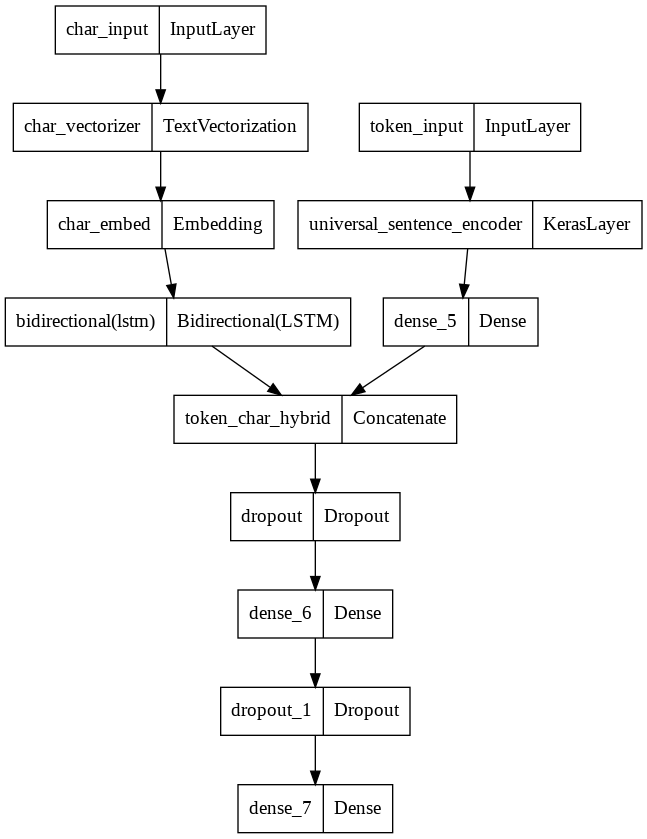

In [46]:
# Plot hybrid token and character model
from tensorflow.keras.utils import plot_model
plot_model(model_4)

In [47]:
# Compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [48]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 

# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Check out training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 8), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 8), dtype=tf.float64, name=None))>)

In [49]:
# Fit the model on tokens and chars
model_4_history = model_4.fit(train_char_token_dataset, # train on dataset of token and characters
                              steps_per_epoch=int(len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(len(val_char_token_dataset)))

Epoch 1/3
438/438 [==============================] - 15s 23ms/step - loss: 1.7857 - accuracy: 0.3318 - val_loss: 1.5929 - val_accuracy: 0.4120
Epoch 2/3
438/438 [==============================] - 10s 22ms/step - loss: 1.5933 - accuracy: 0.4192 - val_loss: 1.5554 - val_accuracy: 0.4370
Epoch 3/3
438/438 [==============================] - 9s 20ms/step - loss: 1.5491 - accuracy: 0.4394 - val_loss: 1.5426 - val_accuracy: 0.4500


In [50]:
# Make predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

array([[0.06968046, 0.3813433 , 0.02523266, ..., 0.04406763, 0.03456238,
        0.1107709 ],
       [0.10432386, 0.07985891, 0.11371843, ..., 0.3242596 , 0.07480898,
        0.09957623],
       [0.09906039, 0.10033116, 0.07441902, ..., 0.11722167, 0.25520954,
        0.11440235],
       ...,
       [0.709944  , 0.09654384, 0.02760937, ..., 0.00994515, 0.02003605,
        0.07326838],
       [0.09560562, 0.45738244, 0.03090233, ..., 0.03250269, 0.1737997 ,
        0.09705254],
       [0.08394863, 0.48059803, 0.02485082, ..., 0.01734845, 0.09371851,
        0.11052062]], dtype=float32)

In [51]:
# Turn prediction probabilities into prediction classes
model_4_preds = tf.argmax(model_4_pred_probs, axis=1) + 1
model_4_preds

<tf.Tensor: shape=(1000,), dtype=int64, numpy=
array([2, 6, 7, 1, 7, 3, 1, 1, 6, 5, 8, 8, 1, 8, 2, 8, 8, 1, 1, 1, 5, 5,
       1, 1, 1, 8, 5, 4, 2, 2, 2, 1, 8, 2, 4, 6, 4, 5, 8, 2, 6, 8, 1, 1,
       2, 8, 2, 7, 5, 1, 2, 2, 5, 5, 6, 1, 2, 6, 2, 6, 1, 2, 3, 8, 3, 1,
       8, 8, 4, 1, 7, 8, 6, 4, 2, 2, 4, 6, 2, 2, 2, 1, 5, 8, 4, 6, 1, 1,
       1, 1, 2, 8, 4, 2, 8, 1, 4, 1, 6, 5, 1, 1, 3, 1, 6, 1, 1, 7, 7, 7,
       8, 8, 1, 2, 1, 5, 5, 5, 4, 1, 2, 3, 2, 1, 7, 2, 1, 5, 7, 1, 5, 6,
       8, 2, 8, 1, 1, 1, 1, 2, 5, 2, 1, 1, 8, 8, 8, 6, 1, 6, 8, 8, 5, 1,
       1, 2, 6, 1, 5, 1, 6, 2, 2, 3, 3, 8, 1, 5, 6, 7, 2, 2, 7, 1, 1, 1,
       2, 6, 3, 6, 2, 5, 7, 3, 4, 8, 5, 5, 8, 5, 2, 2, 6, 4, 5, 8, 1, 7,
       1, 8, 1, 2, 1, 1, 1, 1, 8, 1, 2, 2, 5, 1, 2, 8, 5, 1, 2, 2, 1, 1,
       2, 2, 5, 1, 2, 1, 8, 1, 8, 2, 2, 4, 2, 1, 2, 5, 6, 7, 1, 3, 4, 1,
       3, 1, 2, 1, 3, 5, 8, 1, 1, 6, 7, 3, 1, 8, 6, 5, 5, 1, 2, 2, 1, 4,
       3, 6, 4, 8, 2, 8, 1, 6, 2, 2, 2, 2, 1, 2, 8, 8, 1, 1, 1, 8, 2, 8,
    

In [52]:
# Get results of token-char-hybrid model
model_4_results = calculate_results(y_true=val_labels,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 45.0,
 'f1': 0.4400265694394553,
 'precision': 0.4492801468539967,
 'recall': 0.45}

## Compare model results

In [53]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"custom_token_embed_conv1d": model_1_results,
                                  "pretrained_token_embed": model_2_results,
                                  "custom_char_embed_conv1d": model_3_results,
                                  "hybrid_char_token_embed": model_4_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
custom_token_embed_conv1d,35.5,0.355624,0.355,0.352212
pretrained_token_embed,45.8,0.458435,0.458,0.450423
custom_char_embed_conv1d,28.0,0.265614,0.280,0.236619
hybrid_char_token_embed,45.0,0.449280,0.450,0.440027


## Prediction - Model 2

In [54]:
# Save best performing model to SavedModel format
model_2.save("tf_universal_sentence_model")

INFO:tensorflow:Assets written to: tf_universal_sentence_model/assets


INFO:tensorflow:Assets written to: tf_universal_sentence_model/assets


In [55]:
model_path = "/content/tf_universal_sentence_model"

# Load downloaded model from Google Storage
loaded_model = tf.keras.models.load_model(model_path)

In [56]:
# Converting test_set sentences
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences))
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [68]:
# Make predictions on the test dataset
test_pred_probs = loaded_model.predict(test_dataset,
                                       verbose=1)
test_preds = tf.argmax(test_pred_probs, axis=1) +1

# Inserting the emotion column in test_set dataframe
test_df['emotion'] = test_preds

# Save to csv
test_df.to_csv(r'/content/test_set_predicted.txt', index=False, sep='\t')

test_df

63/63 [==============================] - 1s 8ms/step


,sentence,emotion
0,"Come , let's go get that automobile .",2
1,"Well , some other time , then ?",2
2,He's in trouble . Boy ?,3
3,Criminal gang unit to take control .,4
4,By Molto . No discussion . Interview .,1
...,...,...
1995,Let's do some good .,2
1996,"Hey , you're looking good .",5
1997,"Have they moved the embassy , or are you hijac...",7
1998,What that !,1


[1 2 3 4 5 6 7 8]


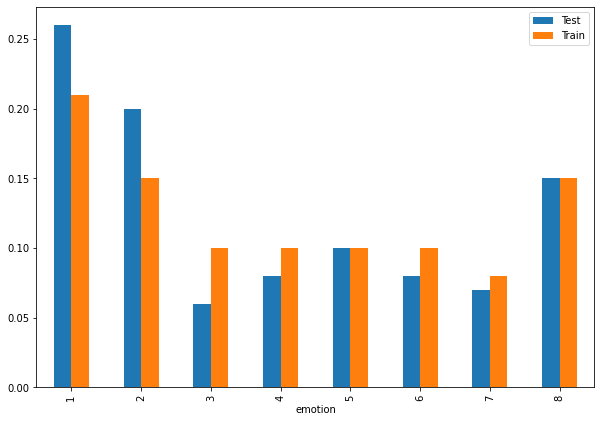

In [65]:
# check the emotions defined:
print(np.sort(test_df['emotion'].unique()))

# check the distribution of sentences in each emotion class:
dft = test_df.groupby('emotion').count().reset_index()
sum_total = dft['sentence'].sum()
dft['perc_total'] = round(dft['sentence']/sum_total,2)
dft['dataset'] = 'Test'
df = df.append(dft)

df_plt = df.pivot(index='emotion', columns='dataset', values='perc_total')

# Plot and compare class distribution of the datasets
df_plt.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0))

plt.show()

In [76]:
# Analyze predictions valid dataframe
valid_df["prediction"] = model_2_preds # create column with test prediction class
valid_df["pred_prob"] = tf.reduce_max(model_2_pred_probs, axis=1).numpy() # get the maximum prediction probability
valid_df["correct"] = valid_df["prediction"] == valid_df["emotion"] # create binary column for whether the prediction is right or not
valid_df.head(2)

,sentence,emotion,prediction,pred_prob,correct
0,What happens to the gold in our safe ?,4,4,0.576391,True
1,Natural to get cold feet .,8,6,0.334920,False


In [75]:
# Find top 20 most wrong samples
top_20_wrong = valid_df[valid_df["correct"] == False].sort_values("pred_prob", ascending=False)[:20]
top_20_wrong

,sentence,emotion,prediction,pred_prob,correct
351,Leave us alone .,4,1,0.938546,False
776,Simply gorgeous .,8,5,0.908190,False
9,Happy may have hit on something tremendous here .,4,5,0.901412,False
117,I look great !,8,5,0.896160,False
948,We're playing with fire .,2,4,0.869198,False
634,You're not going to hang me ?,7,1,0.869110,False
329,See you tomorrow .,8,2,0.864423,False
386,Calm down !,8,1,0.852373,False
13,I can take care of myself !,1,8,0.852229,False
700,I'll see you tomorrow .,8,2,0.843304,False
